### Description of notebook

In this notebook, a balanced random forest (BRF) is trained on the publicly available [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains 284.807 credit card transactions, of which 492 were fraudulent. The dataset is highly unbalanced, the positive class (frauds) accounts for 0.172% of all transactions. 29 transaction features are recorded and used to predict whether a transaction is fraudulent using a BRF model. 

The notebook aims to collect and document best practices for training ML models, with a particular focus on parameter selection and sensitivty testing to balance false positive and false negative rates in model predictions.

Overview of the notebook:
1. Loading libraries
2. Loading and preparing dataset
3. Balanced Random Forest
4. Evaluating model predictions
5. Performing sensitivity testing

### 1. Loading libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, precision_recall_curve, roc_auc_score, PrecisionRecallDisplay
warnings.filterwarnings('ignore')

### 2. Loading and preparing dataset

In [2]:
# Load dataset
data = pd.read_csv('./data/creditcard.csv')

# Drop 'Time' feature as it's not useful for classification
data = data.drop(columns=['Time'])

# Separate features and target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# dimensions
n_samples, n_features = X.shape
print(n_samples, n_features)

284807 29


In [4]:
# preview of data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# imbalancedness of dataset
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### 3. Balanced Random Forest
#### 3.1 Model initialization

In [6]:
# initialize the Balanced Random Forest classifier
clf = BalancedRandomForestClassifier(n_estimators=100, 
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     max_features=X.shape[1],
                                     random_state=42)

#### 3.2 Train and test model using k-fold cross validation

In [7]:
n_splits = 5

def y_proba_real_folds(n_splits, X_set, y_set, clf):
    """
    Computes probabilities  and auc scores for k-folds 

    Parameters
    ----------
    n_splits : number of folds
    X_set: training sample of features
    y_set: training sample with labels
    clf: ML classifier that will assign probability to record 

    Returns
    -------
    List with assigned probabilities per record for all folds, and ground truth labels
    """
    
    # create folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # store predictions and true labels
    all_y_proba_ls = []
    all_y_real_ls = []

    # perform cross-validation 30:70 split
    for train_index, test_index in skf.split(X_set, y_set):
        X_train_fold, X_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # train the model
        clf.fit(X_train_fold, y_train_fold)
        
        # predict probabilities
        y_probs_fold = clf.predict_proba(X_test_fold)[:, 1]
        
        # collect true labels and predicted probabilities
        all_y_proba_ls.append(y_probs_fold.tolist())
        all_y_real_ls.append(y_test_fold.tolist())

    # make lists equal length
    np.append(all_y_proba_ls[4], all_y_proba_ls[4][39871])
    np.append(all_y_real_ls[4], all_y_real_ls[4][39871])
    
    return(all_y_proba_ls, all_y_real_ls)

In [8]:
# Train and test model using k-fold cross validation
all_y_proba_ls, all_y_real_ls = y_proba_real_folds(n_splits, X_train, y_train, clf)

### 4. Evaluating model predictions

#### Function to compute precision, recall and auc scores

In [9]:
def auc_pr_rec_ls(n_splits, all_y_proba_ls, all_y_real_ls):
    """
    Computes precision, recall and auc scores for k-folds 

    Parameters
    ----------
    n_splits : number of folds
    all_y_proba_ls: all probabilities predicted by classifier for all folds in ndarray
    all_y_real_ls: all ground truth labels for all fold splits in ndarray

    Returns
    -------
    Lists with precision, recall and auc scores for all folds 
    """

    # initialize lists
    auc_ls = []
    precision_ls = []
    recall_ls = []

    # plot each fold
    for i in range(0,n_splits):

        # get data from list
        y_proba = all_y_proba_ls[i]
        y_test = all_y_real_ls[i]

        # compute precision-recall pairs for different probability thresholds
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        precision_ls.append(precision)
        recall_ls.append(recall)

        # compute the AUC score
        auc = roc_auc_score(y_test, y_proba)
        auc_ls.append(auc)

    return(auc_ls, precision_ls, recall_ls, thresholds)

In [10]:
# auc, precision and recall for all folds
auc_ls, precision_ls, recall_ls, thresholds = auc_pr_rec_ls(n_splits, all_y_proba_ls, all_y_real_ls)

#### Function to compute average precision, recall across folds

In [11]:
def avg_PR_auc(all_y_real_ls, all_y_proba_ls):
    """
    Computes average precision-recall across the results from all folds

    Parameters
    ----------
    all_y_proba_ls: all probabilities predicted by classifier for all folds in ndarray
    all_y_real_ls: all ground truth labels for all fold splits in ndarray

    Returns
    -------
    precision: average precision score across all folds
    recall: average recall score across all folds
    auc_avg: average auc-score across all folds
    """

    # compute average precision-recall across the results from all folds, after the loop
    y_real = np.concatenate(all_y_real_ls)
    y_proba = np.concatenate(all_y_proba_ls)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    auc_avg = roc_auc_score(y_real, y_proba)

    return(precision, recall, auc_avg)

#### Plot functions for PR curves per fold and averages for standard parameters
For imbalanced datasets, plotting precision-recall is preferred over ROC-curve.

As the ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR). However, in the case of imbalanced datasets, where the negative class (majority class) dominates, the FPR can remain artificially low, making the ROC curve appear overly optimistic. This is because the number of false positives (FP) is relatively small compared to the true negatives (TN), even when the classifier is not performing well on the minority class.

The PR curve plots Precision (Positive Predictive Value) against Recall (TPR). Precision is directly affected by the number of false positives, which is more relevant when dealing with imbalanced datasets. As a result, the PR curve gives a clearer view of how well the classifier is distinguishing the minority class from the majority class.

In [12]:
def closest_index(lst, value):
    """
    Computes index of numeric elements in list that is closest to value of interest
    """   
    return min(range(len(lst)), key=lambda i: abs(lst[i] - value))


def plot_avg_PR(n_splits, all_y_proba_ls, all_y_real_ls, color, main_plot=None, thres_marker=None, **kwargs):
    """
    Computes average PR curve based on k-folds 

    Parameters
    ----------
    n_splits : number of folds
    all_y_proba_ls: all probabilities predicted by classifier for all folds in ndarray
    all_y_real_ls: all ground truth labels for all fold splits in ndarray
    main_plot: parameter to enable plot labels and title if this function creates the main plot

    Returns
    -------
    Plot with PR curve averaged over all folds
    """

    # compute average precision-recall across the results from all folds
    precision, recall, auc_avg = avg_PR_auc(all_y_real_ls, all_y_proba_ls)

    # plot average of all folds
    if main_plot == 'yes' and 'params' in kwargs:
        n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = kwargs['params']
        plt.plot(recall, precision, marker='.', color=color, alpha=0.2, label=f'n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, max_features={max_features}')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=1)
    elif main_plot == 'yes':
        plt.plot(recall, precision, marker='.', color=color)
    else:
        plt.plot(recall, precision, marker='.', label=f'PR average (AUC={auc_avg:.2f})', color=color)

    # marker for threshold of interest
    if thres_marker == 'yes':
        thresholds = kwargs['thresholds']
        thres = kwargs['thres']
        index = closest_index(thresholds, thres)

        # Plot point from confusion matrix
        plt.scatter(recall[index], precision[index], color='red', marker='x', label=f'Threshold = {thres}', zorder=4)

    if main_plot == 'yes':
        # axis and title
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Average PR curves')

        plt.grid(True)
        

def std_folds(precision_ls, recall_ls):
    """
    Computes mean and standard deviation of precision and recall across all folds

    Parameters
    ----------
    precision_ls : number of folds
    recall_ls: all probabilities predicted by classifier for all folds in ndarray

    Returns
    -------
    mean_recall: mean recall
    mean_precision: mean precision
    precision_lower: 1 std lower bound precision score 
    precision_upper: 1 std upper bound precision score
    """

    # compute mean, std folds
    mean_recall = np.mean(recall_ls, axis=0)
    mean_precision = np.mean(precision_ls, axis=0)
    std_precision = np.std(precision_ls, axis=0)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)

    return(mean_recall, mean_precision, precision_lower, precision_upper)


def plot_all_folds(n_splits, auc_ls, precision_ls, recall_ls, color='Blue', avg_plot=None, std_plot=None, thres_marker=None, **kwargs):
    """
    Computes PR curve for all k-folds 

    Parameters
    ----------
    n_splits : number of folds
    auc_ls: auc value per fold
    precision_ls: precision scores per fold
    recall_ls: all ground truth labels for all fold splits in ndarray
    thres: threshold of interest
    plot_avg: if the average across all folds should be plotted
    std_plot: if the 1 std upper and lower bound around the average PR curve should be plotted

    Returns
    -------
    Plot with average PR curve
    """

    plt.figure(figsize=(10, 6))

    i=0
    for auc, precision, recall in zip(auc_ls, precision_ls, recall_ls):
        # Plot PR curve
        plt.plot(recall, precision, marker='.', label=f'PR fold {i} (AUC={auc:.2f})', alpha=0.2)
        i += 1

    # plot standard deviation based on all folds
    if std_plot == 'yes':
        mean_recall, mean_precision, precision_lower, precision_upper = std_folds(precision_ls, recall_ls)

        # plot averages
        plt.fill_between(
            mean_recall,
            precision_lower,
            precision_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 standard deviation",
        )

    # plot average of folds
    if avg_plot == 'yes':
        if thres_marker == 'yes':
            thresholds = kwargs['thresholds']
            thres = kwargs['thres']
            plot_avg_PR(n_splits, all_y_proba_ls, all_y_real_ls, color, thres_marker='yes', thresholds=thresholds, thres=thres)
        else:
            plot_avg_PR(n_splits, all_y_proba_ls, all_y_real_ls, color)

    # axis and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Cross Validated {n_splits}-folds PR curve')

    plt.legend()
    plt.grid(True)
    plt.show()

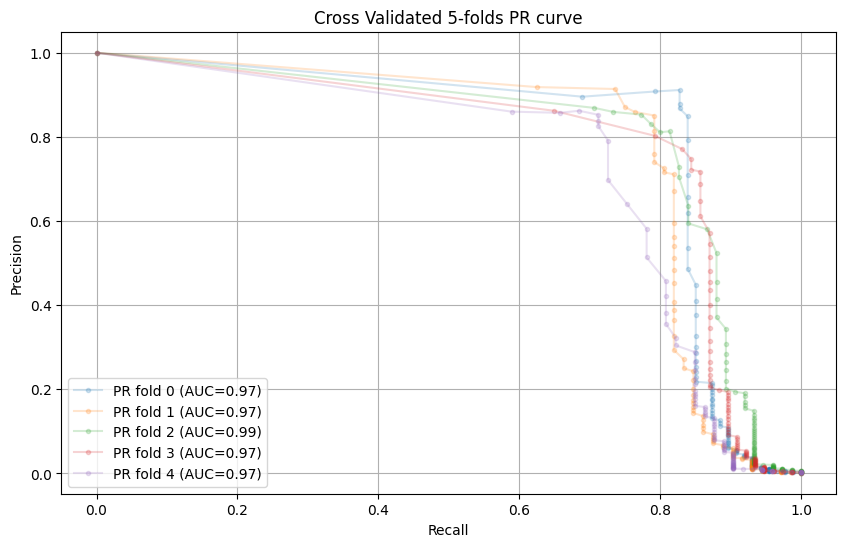

In [13]:
# all folds without average and standard deviation
plot_all_folds(n_splits, auc_ls, precision_ls, recall_ls)

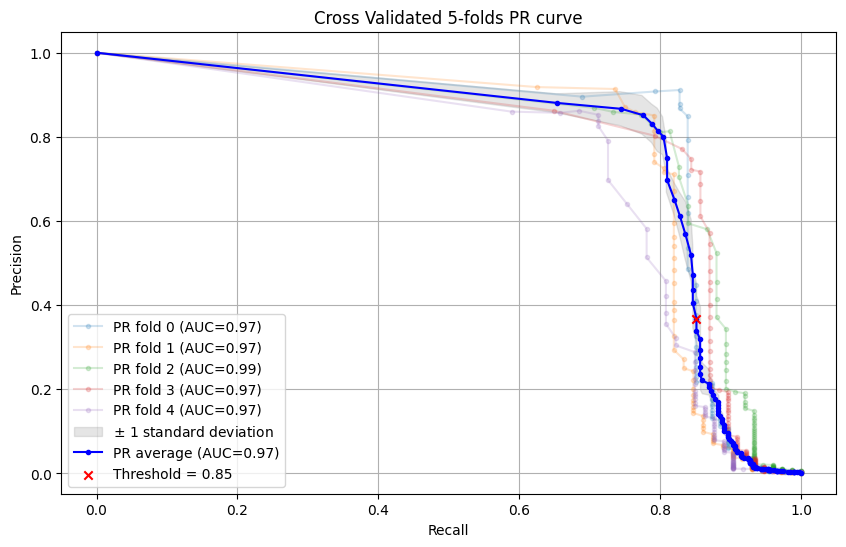

In [14]:
# all folds with average, standard deviation and threshold marker
thres = 0.85
plot_all_folds(n_splits, auc_ls, precision_ls, recall_ls, avg_plot='yes', std_plot='yes', thres_marker = 'yes', thresholds=thresholds, thres=thres)

### 5. Sensitivity testing

In [15]:
def BRF_sensitivity_testing(n_splits, X_train, y_train, all_comb):
    """
    Plots average PR curve based on k-folds for various parameter combinatitions

    Parameters
    ----------
    n_splits : number of folds
    X_train: train dataset
    y_train: test dataset
    all_comb: all combinations of parameters

    Returns
    -------
    Plot with average PR curves for all combination of parameters
    """

    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap('Set1')

    i=0
    for elm in all_comb:
        i += 1

        # get parameter combination
        n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = elm
        print(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
        
        # BRF model classifications
        clf = BalancedRandomForestClassifier(n_estimators=n_estimators, 
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            max_features=max_features,
                                            random_state=42)

        # Train and test model using k-fold cross validation
        all_y_proba_ls, all_y_real_ls = y_proba_real_folds(n_splits, X_train, y_train, clf)

        # plot color
        color = cmap(i % 8)

        # plot average of all folds
        plot_avg_PR(n_splits, all_y_proba_ls, all_y_real_ls, color, main_plot='yes', params=elm)

In [16]:
# parameter sweep
n_estimator_ls = [100, 200, 300]
max_depth_ls = [None, 1, 5]
min_samples_split_ls = [2, 3, 5, 10]
min_samples_leaf_ls = [1, 3, 5]
max_features = [X.shape[1]]

# get all combinations of parameters
all_comb = list(product(n_estimator_ls, max_depth_ls, min_samples_split_ls, min_samples_leaf_ls, max_features))

# plot results
BRF_sensitivity_testing(n_splits, X_train, y_train, all_comb)

100 None 2 1 29
100 None 2 3 29
100 None 2 5 29
100 None 3 1 29
100 None 3 3 29
100 None 3 5 29
100 None 5 1 29
100 None 5 3 29
100 None 5 5 29
100 None 10 1 29
100 None 10 3 29
100 None 10 5 29
100 1 2 1 29
100 1 2 3 29
100 1 2 5 29
100 1 3 1 29
100 1 3 3 29
100 1 3 5 29
100 1 5 1 29
100 1 5 3 29
100 1 5 5 29
100 1 10 1 29
100 1 10 3 29
100 1 10 5 29
100 5 2 1 29
100 5 2 3 29
100 5 2 5 29
100 5 3 1 29
100 5 3 3 29
100 5 3 5 29
100 5 5 1 29
100 5 5 3 29
100 5 5 5 29
100 5 10 1 29
100 5 10 3 29
100 5 10 5 29
200 None 2 1 29
200 None 2 3 29
200 None 2 5 29
200 None 3 1 29
200 None 3 3 29
200 None 3 5 29
200 None 5 1 29
200 None 5 3 29
200 None 5 5 29
200 None 10 1 29
200 None 10 3 29
200 None 10 5 29
200 1 2 1 29
200 1 2 3 29
200 1 2 5 29
200 1 3 1 29
200 1 3 3 29
200 1 3 5 29
200 1 5 1 29
200 1 5 3 29
200 1 5 5 29
200 1 10 1 29
200 1 10 3 29
200 1 10 5 29
200 5 2 1 29
200 5 2 3 29
200 5 2 5 29
200 5 3 1 29
200 5 3 3 29
200 5 3 5 29
200 5 5 1 29
200 5 5 3 29
200 5 5 5 29
200 5 10 1 29
20